In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import datetime
import os

from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
from models.vae import DenseVariationalAutoencoder
#disable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

TRAINING_FRACTION = 0.8
N_DENSE = 2
L=4
NON_LINEAR_ACTIVATION_BOOL=True

In [2]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
#DATA_NAME = 'digits'
DATA_NAME = 'xy'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [3]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"
    
tensorboard_log_dir = "{}/logs/fit/".format(prefix_s3) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [4]:
# Just do this so it is easier to configure arbitrary choices
work_with_t_list = [ "00.10", "00.20", "00.30", "00.40", "00.50", "00.60", "00.70", "00.80", "00.90", "01.00", "01.10", "01.20", "01.30", "01.40", "01.50", "01.60", "01.70", "01.80", "01.90", "02.00"]

In [5]:
df_bins = None
df_conf = None
for i, t_string in enumerate(work_with_t_list):
    bins_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/bins_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    configs_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/spinConfigs_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    if i == 0:
        df_bins = pd.read_csv(bins_f_name, sep="\t")
        df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
    else:
        cur_df_bins = pd.read_csv(bins_f_name, sep="\t")
        cur_df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
        df_bins = df_bins.append(cur_df_bins) 
        df_conf = df_conf.append(cur_df_conf) 
    print(bins_f_name)

/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.10-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.20-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.30-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.40-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.50-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.60-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.70-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.80-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.90-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-

In [6]:
df_bins.shape

(200000, 10)

In [7]:
df_bins = df_bins.astype(
    {
        " T ": float,
        " binNum": int,
    }
)

In [8]:
df_conf["T"] = df_bins[" T "]

In [9]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [10]:
df_conf["M"] = mean_col

In [11]:
df_conf.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'T', 'M'], dtype='object')

In [12]:
df_conf.shape

(200000, 18)

In [13]:
df_conf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,T,M
0,0.162246,5.973095,6.133531,6.156717,0.025063,6.050038,6.020508,6.223365,0.067779,6.153401,6.032560,0.073008,6.134114,6.160847,0.052111,0.115091,0.1,4.606397
1,4.983357,4.822849,4.691446,4.885390,5.122919,4.853683,4.793827,4.921220,4.869675,5.132625,5.236716,4.908288,4.935758,4.859949,4.700985,5.001698,0.1,4.845760
2,2.727240,2.390374,2.708473,2.618912,2.354293,2.384652,2.535973,2.779869,2.592872,2.413333,2.715683,2.716086,2.763101,2.847251,2.660584,2.721994,0.1,2.611250
3,5.762936,5.839879,0.023180,6.216394,6.118754,6.144861,0.033664,0.032085,6.282960,0.085963,0.031738,0.152408,6.027732,6.234099,0.083261,0.023046,0.1,4.460597
4,4.463147,4.564015,4.342138,4.595675,4.269949,4.323170,4.407668,4.411044,4.368104,4.413393,4.490482,4.530060,4.503687,4.435605,4.239925,4.452277,0.1,4.491244


In [14]:
cols = []
for i in range(L*L):
    cols.append(str(i))
    cols.append(str(i))
print(cols)

['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', '10', '10', '11', '11', '12', '12', '13', '13', '14', '14', '15', '15']


In [15]:
xy_spec = ["x", "y"] * L*L

In [16]:
for i in zip(cols, xy_spec):
    continue
    #print(i)

In [17]:
np_angle_matrix = df_conf.drop(["T","M"], axis=1).to_numpy()

In [18]:
np_x_matrix = np.cos(np_angle_matrix)
np_y_matrix = np.sin(np_angle_matrix)

In [19]:
#np.concatenate(np_x_matrix, np_x_matrix, axis=1)
df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(zip(cols, xy_spec)))

In [20]:
df.sort_index(ascending=True, inplace=True, axis=1)

In [21]:
df.loc[:, (slice(None), slice("x"))] = np_x_matrix

In [22]:
np_x_matrix

array([[ 0.986867  ,  0.9523061 ,  0.98882268, ...,  0.99252601,
         0.99864253,  0.99338439],
       [ 0.26766423,  0.11023518, -0.0209416 , ...,  0.14702497,
        -0.01140408,  0.28528988],
       [-0.91537707, -0.73085744, -0.90766075, ..., -0.95699346,
        -0.88652882, -0.91325267],
       ...,
       [-0.99830957,  0.0421496 ,  0.89964396, ...,  0.21996072,
        -0.50070655,  0.84040243],
       [ 0.82732545, -0.5923434 , -0.93039124, ...,  0.97941924,
         0.99797575,  0.46533788],
       [-0.13212106, -0.07885553, -0.83045631, ..., -0.38073196,
        -0.00149156, -0.17984246]])

In [23]:
np_y_matrix

array([[ 0.16153491, -0.30514438, -0.14909632, ..., -0.12203327,
         0.05208737,  0.11483667],
       [-0.96351225, -0.99390553, -0.9997807 , ..., -0.98913278,
        -0.99993497, -0.95844128],
       [ 0.40259759,  0.68253015,  0.41970462, ...,  0.29010949,
         0.46267338,  0.40739362],
       ...,
       [ 0.05812054,  0.99911131,  0.43662425, ..., -0.97550873,
         0.86561709, -0.54196287],
       [ 0.56172289,  0.80568561,  0.36656806, ...,  0.20183644,
        -0.06359564,  0.88513313],
       [-0.99123359, -0.99688605,  0.55708377, ...,  0.92468545,
         0.99999889, -0.98369542]])

In [24]:
df.loc[:, (slice(None), "y")] = np_y_matrix

In [25]:
df

0                   1                  10                  11  \
               x         y         x         y         x         y         x   
0       0.986867  0.161535  0.952306 -0.305144  0.988823 -0.149096  0.992013   
1       0.267664 -0.963512  0.110235 -0.993906 -0.020942 -0.999781  0.172139   
2      -0.915377  0.402598 -0.730857  0.682530 -0.907661  0.419705 -0.866484   
3       0.867695 -0.497097  0.903339 -0.428928  0.999731  0.023177  0.997770   
4      -0.246669 -0.969100 -0.147830 -0.989013 -0.361850 -0.932236 -0.116449   
...          ...       ...       ...       ...       ...       ...       ...   
199995 -0.380816  0.924651  0.435527  0.900176 -0.992033  0.125981 -0.960587   
199996  0.599849  0.800113 -0.901182  0.433442  0.110907 -0.993831 -0.260379   
199997 -0.998310  0.058121  0.042150  0.999111  0.899644  0.436624  0.981281   
199998  0.827325  0.561723 -0.592343  0.805686 -0.930391  0.366568  0.705829   
199999 -0.132121 -0.991234 -0.078856 -0.996886 -0.830456  0.557084  0.912044   

                        12            ...         5                   6  \
               y         x         y  ...         x         y         x   
0      -0.126132  0.999686  0.025061  ...  0.997336  0.072943  0.988909   
1      -0.985073  0.399095 -0.916909  ...  0.194648 -0.980873  0.221516   
2       0.499204 -0.705761  0.708450  ... -0.910830  0.412782 -0.929223   
3      -0.066742  0.986512 -0.163692  ...  0.988408  0.151819  0.967549   
4      -0.993197 -0.428146 -0.903710  ... -0.181321 -0.983424 -0.207191   
...          ...       ...       ...  ...       ...       ...       ...   
199995  0.277981 -0.778302  0.627890  ... -0.934569  0.355781 -0.953145   
199996  0.965507  0.960891 -0.276929  ...  0.862163 -0.506631  0.249771   
199997  0.192584 -0.785513 -0.618845  ...  0.686430 -0.727196  0.770983   
199998  0.708382  0.868733 -0.495281  ... -0.681993  0.731359 -0.858536   
199999  0.410093 -0.956530  0.291633  ... -0.751057 -0.660238 -0.531589   

                         7                   8                   9            
               y         x         y         x         y         x         y  
0      -0.148520  0.992526 -0.122033  0.998643  0.052087  0.993384  0.114837  
1      -0.975157  0.147025 -0.989133 -0.011404 -0.999935  0.285290 -0.958441  
2       0.369519 -0.956993  0.290109 -0.886529  0.462673 -0.913253  0.407394  
3      -0.252684  0.998796 -0.049066  0.996536  0.083165  0.999734  0.023044  
4      -0.978301 -0.273263 -0.961939 -0.455082 -0.890450 -0.257189 -0.966361  
...          ...       ...       ...       ...       ...       ...       ...  
199995  0.302513 -0.190073 -0.981770 -0.903206  0.429207  0.218889  0.975750  
199996  0.968305 -0.818960  0.573851 -0.532814 -0.846232  0.187749  0.982217  
199997 -0.636856  0.219961 -0.975509 -0.500707  0.865617  0.840402 -0.541963  
199998  0.512753  0.979419  0.201836  0.997976 -0.063596  0.465338  0.885133  
199999 -0.847003 -0.380732  0.924685 -0.001492  0.999999 -0.179842 -0.983695  

[200000 rows x 32 columns]

In [26]:
train_with_meta_info = df.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = df.drop(index=train_with_meta_info.index)
#train = train_with_meta_info.drop(["T","M"], axis=1)
#test = test_with_meta_info.drop(["T","M"], axis=1)
train = train_with_meta_info
test = test_with_meta_info

In [27]:
img_pca = PCA(n_components=N_DENSE)
img_pca.fit(train.to_numpy())

PCA(n_components=2)

In [28]:
components = img_pca.transform(df.to_numpy())

In [29]:
df.to_numpy().shape

(200000, 32)

In [30]:
components.shape

(200000, 2)

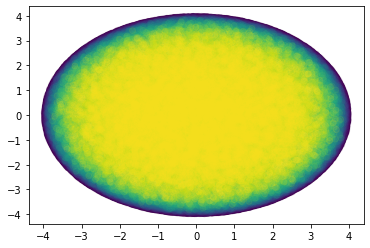

In [31]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["T"]), alpha=0.1)

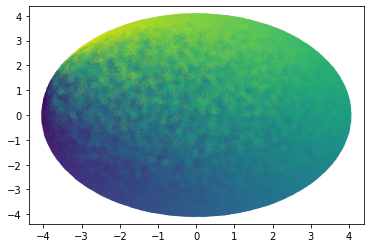

In [32]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["M"]), alpha=0.1)

# Dense AE

In [33]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L*2,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L*2),
    ]
)

print(simp_ae.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 2)                 64        
                                                                 
 dense (Dense)               (None, 32)                96        
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


2022-08-30 22:39:28.291916: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-30 22:39:28.291938: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-08-30 22:39:28.291942: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-08-30 22:39:28.291993: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.141.3
2022-08-30 22:39:28.292009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.141.3
2022-08-30 22:39:28.292013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.141.3
2022-08-30 22:39:28.292340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

In [34]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=0,  
    write_graph=True,
    write_images=True
)

simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [35]:
simp_ae.fit(
    batch_size=16,
    x=train.to_numpy(),
    y=train.to_numpy(),
    epochs=20,
    callbacks=[tb_callback]
)

Epoch 1/20
10000/10000 [==============================] - 10s 934us/step - loss: 0.2000 - mae: 0.3347
Epoch 2/20
10000/10000 [==============================] - 9s 941us/step - loss: 0.1910 - mae: 0.3257
Epoch 3/20
10000/10000 [==============================] - 9s 922us/step - loss: 0.1910 - mae: 0.3257
Epoch 4/20
10000/10000 [==============================] - 8s 824us/step - loss: 0.1910 - mae: 0.3257
Epoch 5/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1910 - mae: 0.3256
Epoch 6/20
10000/10000 [==============================] - 10s 1000us/step - loss: 0.1910 - mae: 0.3256
Epoch 7/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1910 - mae: 0.3256
Epoch 8/20
10000/10000 [==============================] - 10s 972us/step - loss: 0.1910 - mae: 0.3256
Epoch 9/20
10000/10000 [==============================] - 10s 999us/step - loss: 0.1910 - mae: 0.3256
Epoch 10/20
10000/10000 [==============================] - 10s 973us/step - loss: 0.1910

In [36]:
mid_layer = simp_ae.get_layer('latent_space')

In [37]:
mid_layer.get_weights()[0].shape

(32, 2)

In [38]:
extractor = keras.Model(inputs=simp_ae.inputs,
                        outputs=[layer.output for layer in simp_ae.layers])

In [39]:
features = extractor(df.to_numpy())

In [40]:
features[0]

<tf.Tensor: shape=(200000, 2), dtype=float32, numpy=
array([[-1.3602887 , -0.29000616],
       [-0.12695111, -1.4134393 ],
       [ 1.1141955 ,  0.85279393],
       ...,
       [-0.58732355,  0.1996884 ],
       [-0.06488425,  0.6769451 ],
       [ 0.31997064,  0.16234165]], dtype=float32)>

In [41]:
features[0][:,0]

<tf.Tensor: shape=(200000,), dtype=float32, numpy=
array([-1.3602887 , -0.12695111,  1.1141955 , ..., -0.58732355,
       -0.06488425,  0.31997064], dtype=float32)>

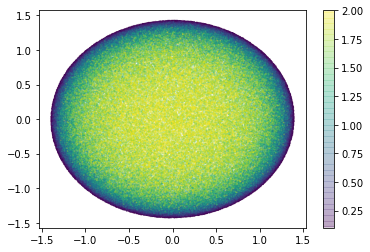

In [42]:
plt.scatter(features[0][:,0], features[0][:,1], c=df_conf["T"], s=0.5, alpha=0.2)
plt.colorbar()

# Dense VAE

In [43]:
x = train.to_numpy().reshape(-1,L*L*2)
x_test = test.to_numpy().reshape(-1,L*L*2)
x = x.astype(float)
x_test = x_test.astype(float)

In [44]:
print(x.shape)
print(x_test.shape)

(160000, 32)
(40000, 32)


In [45]:
print(type(x))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [46]:
#x = x+10
#x_test = x_test+10

In [54]:
# Need to do this for VAE but cant have it on for the feature and scatter stuff for the normal AE above
disable_eager_execution()
vae = DenseVariationalAutoencoder(
    input_dim=(L*L*2,),
    encoder_layer_sizes=[2],
    decoder_layer_sizes=[2, L*L*2],
    z_dim=N_DENSE,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)

In [55]:
LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 1000
R_LOSS_FACTOR = 1000

In [56]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [57]:
BATCH_SIZE = 16
EPOCHS = 5
PRINT_EVERY_N_BATCHES = 10
INITIAL_EPOCH = 0

In [58]:
#x.shape
#vae.encoder.summary()
vae.decoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 2)                 6         
                                                                 
 dense_7 (Dense)             (None, 2)                 6         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 2)                 0         
                                                                 
 dense_8 (Dense)             (None, 32)                96        
                                                                 
 activation_1 (Activation)   (None, 32)                0         
                                                                 
Total params: 108
Trainable params: 108
Non-trainable param

In [59]:
r = vae.train(     
    x,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = INITIAL_EPOCH,
    #x_test=tf.data.Dataset.from_tensor_slices(x_test)
)

Train on 80000 samples, validate on 80000 samples
Epoch 1/5
 1360/80000 [..............................] - ETA: 6s - loss: 739.6370 - vae_r_loss: 738.9886 - vae_kl_loss: 0.6482  

2022-08-30 22:44:07.111917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-08-30 22:44:07.245891: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-08-30 22:44:07.245909: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-08-30 22:44:07.248936: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-30 22:44:07.249959: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-08-30 22:44:07.251484: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /home/owen/logs/fit/20220830-224406/plugins/profile/2022_08_30_22_44_07

2022-08-30 22:44:07.251960: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to /home/owen/logs/fit/20220830-224406/plugins/profile/2022_08_30_22_44_07/owen-PRIME-Z390-A.trace.json.

78912/80000 [============================>.] - ETA: 0s - loss: 452.6663 - vae_r_loss: 442.2071 - vae_kl_loss: 10.4596

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


80000/80000 [==============================] - 6s 69us/sample - loss: 451.4857 - vae_r_loss: 441.0386 - vae_kl_loss: 10.4476 - val_loss: 364.9253 - val_vae_r_loss: 356.0087 - val_vae_kl_loss: 8.9167
Epoch 2/5
80000/80000 [==============================] - 7s 83us/sample - loss: 359.4303 - vae_r_loss: 352.6023 - vae_kl_loss: 6.8276 - val_loss: 357.1599 - val_vae_r_loss: 351.5366 - val_vae_kl_loss: 5.6228
Epoch 3/5
80000/80000 [==============================] - 7s 84us/sample - loss: 354.8318 - vae_r_loss: 349.5909 - vae_kl_loss: 5.2408 - val_loss: 354.3787 - val_vae_r_loss: 349.4287 - val_vae_kl_loss: 4.9499
Epoch 4/5
80000/80000 [==============================] - 7s 91us/sample - loss: 352.8390 - vae_r_loss: 348.0151 - vae_kl_loss: 4.8235 - val_loss: 353.0681 - val_vae_r_loss: 348.3850 - val_vae_kl_loss: 4.6832
Epoch 5/5
80000/80000 [==============================] - 6s 76us/sample - loss: 351.8519 - vae_r_loss: 347.2384 - vae_kl_loss: 4.6133 - val_loss: 352.2809 - val_vae_r_loss: 347.